In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE_DIR= "/content/drive/MyDrive/output_maskrcnn_resnext101_v1"

In [ ]:
"""
Run this first to verify you have GPU access
"""
!nvidia-smi
!python --version

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")


Tue Dec  9 13:36:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
"""
Install all required libraries
This will take 3-5 minutes
"""
# Install PyTorch and torchvision (with CUDA support)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install Detectron2
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install other dependencies
!pip install roboflow opencv-python matplotlib pycocotools

# Verify installations
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

print(f"✓ Detectron2 version: {detectron2.__version__}")
print("✓ All dependencies installed successfully!")


Looking in indexes: https://download.pytorch.org/whl/cu118
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-65qvu0iu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-65qvu0iu
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.0 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=7085042 sha256=0ff508fba7ad45e890fa90a11229abbb42e0c44139f122a8c7d1800157a55bee
  Stored in directory: /tmp/pip-

In [ ]:
"""
This Cell is for Roboflow Setup and Data Loading from it
"""
from roboflow import Roboflow
import os

# ===== CONFIGURE THESE =====
ROBOFLOW_API_KEY = "McrhzGgUVuaQbO2a1BX6"  # Your actual API key
WORKSPACE_NAME = "chandai"                 # Your workspace name
PROJECT_NAME = "lunar-scene-analysis-fejkh" # Your project name
VERSION_NUMBER = 5                          # Dataset version number
# Initialize Roboflow
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace(WORKSPACE_NAME).project(PROJECT_NAME)

# Download dataset in COCO format
print("Downloading dataset from RoboFlow...")
dataset = project.version(VERSION_NUMBER).download("coco")

# Get dataset location
dataset_location = dataset.location
print(f"✓ Dataset downloaded to: {dataset_location}")

# Verify dataset structure
print("\nDataset structure:")
for root, dirs, files in os.walk(dataset_location):
    level = root.replace(dataset_location, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Lunar-Scene-Analysis-5 in coco:: 100%|██████████| 1244/1244 [00:00<00:00, 4378.69it/s]

✓ Dataset downloaded to: /content/Lunar-Scene-Analysis-5

Dataset structure:
Lunar-Scene-Analysis-5/
  README.roboflow.txt
  README.dataset.txt
  valid/
    chang4_20190106042724_png.rf.6aefd122e6d1acbd62056a0f538c8189.jpg
    chang4_20190111191749_png.rf.377d86f9fdc48363ac30dd1dd0449868.jpg
    _annotations.coco.json
    C3_TCAM_4_2C_236_png.rf.52c84c4fb09442c451a40d8fc293a7aa.jpg
    PCAML-C-003_SCI_N_20140113190245_0008_A_2C_png.rf.09c211fd0ab810fd78760bca0c23c68c.jpg
    ... and 95 more files
  train/
    PCAML-C-001_SCI_N_20140112131151_0007_A_2C_png.rf.e9b83cd7897394d711f2aa0ec513ccfb.jpg
    PCAML-C-035_SCI_N_20140112134924_0007_A_2C_png.rf.2909b2000e89e867ef33a8ead395ecd0.jpg
    PCAML-C-044_SCI_N_20140112135845_0007_A_2C_png.rf.90fe28e0533855b7736791b4a3e871d2.jpg
    PCAML-Q-101_SCI_N_20131223012534_0005_A_2A_png.rf.69af18274d7130186e4039cab58a937e.jpg
    PCAML-Q-038_SCI_N_20131223002148_0005_A_2A_png.rf.bf3c3acdd6924b441bc49ac8f0218b8f.jpg
    ... and 1085 more files
  test

In [ ]:
"""
Registering our COCO-format dataset with Detectron2
"""
from detectron2.data.datasets import register_coco_instances
import json

# Define paths
TRAIN_JSON = os.path.join(dataset_location, "train", "_annotations.coco.json")
TRAIN_IMG_DIR = os.path.join(dataset_location, "train")
VAL_JSON = os.path.join(dataset_location, "valid", "_annotations.coco.json")
VAL_IMG_DIR = os.path.join(dataset_location, "valid")
TEST_JSON = os.path.join(dataset_location, "test", "_annotations.coco.json")
TEST_IMG_DIR = os.path.join(dataset_location, "test")

# Verify files exist
print("Checking dataset files...")
assert os.path.exists(TRAIN_JSON), f"Train annotations not found at {TRAIN_JSON}"
assert os.path.exists(VAL_JSON), f"Valid annotations not found at {VAL_JSON}"
print("✓ All annotation files found")

# Register datasets
register_coco_instances("lunar_train", {}, TRAIN_JSON, TRAIN_IMG_DIR)
register_coco_instances("lunar_val", {}, VAL_JSON, VAL_IMG_DIR)
register_coco_instances("lunar_test", {}, TEST_JSON, TEST_IMG_DIR)

print("✓ Datasets registered successfully!")

# Get dataset info
print("\nDataset Information:")
print(f"Training set: {len(DatasetCatalog.get('lunar_train'))} images")
print(f"Validation set: {len(DatasetCatalog.get('lunar_val'))} images")
print(f"Test set: {len(DatasetCatalog.get('lunar_test'))} images")

# Get class names
metadata = MetadataCatalog.get("lunar_train")
class_names = metadata.thing_classes
num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {class_names}")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Checking dataset files...
✓ All annotation files found
✓ Datasets registered successfully!

Dataset Information:
Training set: 1089 images
Validation set: 99 images
Test set: 48 images

Number of classes: 7
Classes: ['objects', 'artifact', 'boulder', 'crater', 'rock', 'rocky region', 'rover path']


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Visualizing 3 random training samples:

Sample 1:
  - Image: chang4_20190106033418_png.rf.5f5e742df78b9ab5b59651fab3ab572d.jpg
  - Annotations: 1 objects


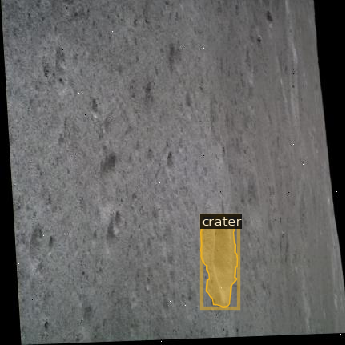


Sample 2:
  - Image: chang4_20190106035129_png.rf.ab034d1f65f701a7d0cfc896b99a6efc.jpg
  - Annotations: 2 objects


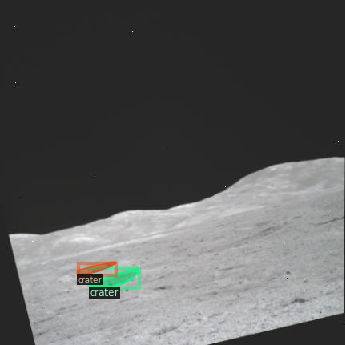


Sample 3:
  - Image: C3_TCAM_2_2C_015_png.rf.45debc006f688449f7faf3f21a3eb186.jpg
  - Annotations: 6 objects


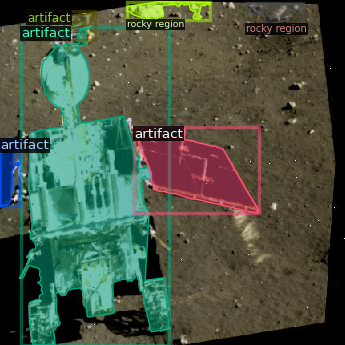

In [ ]:
"""
Visualizing a few training samples to verify data quality
"""
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

# Get random samples from training set
dataset_dicts = DatasetCatalog.get("lunar_train")
samples = random.sample(dataset_dicts, min(3, len(dataset_dicts)))

print(f"Visualizing {len(samples)} random training samples:\n")

for idx, d in enumerate(samples):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
    vis = visualizer.draw_dataset_dict(d)

    print(f"Sample {idx + 1}:")
    print(f"  - Image: {os.path.basename(d['file_name'])}")
    print(f"  - Annotations: {len(d['annotations'])} objects")
    cv2_imshow(vis.get_image()[:, :, ::-1])
    print()

In [ ]:
"""
Configurations for Mask R-CNN + ResNeXt-101-32x8d-FPN
"""
import os
from detectron2.config import get_cfg
from detectron2 import model_zoo

RESUME = False

def get_resnext101_cfg():
    global RESUME  # Declare intent to modify global RESUME
    cfg = get_cfg()

    # ===== LOAD RESNEXT-101 BASE MODEL =====
    # ResNeXt-101-32x8d with FPN - Native Detectron2 support
    cfg.merge_from_file(
        model_zoo.get_config_file(
            "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
        )
    )

    # Path to checkpoint for resuming
    last_ckpt_file = os.path.join(DRIVE_DIR, "last_checkpoint")
    if os.path.exists(last_ckpt_file):
        print("Resuming training from last checkpoint!")
        cfg.MODEL.WEIGHTS = last_ckpt_file
        RESUME = True
    else:
        print("No checkpoint found! Starting fresh with COCO pretrained weights.")
        # Load COCO pretrained weights for transfer learning
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
            "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
        )
        RESUME = False

    # ===== DATASET =====
    cfg.DATASETS.TRAIN = ("lunar_train",)
    cfg.DATASETS.TEST = ("lunar_val",)

    # ===== DATALOADER =====
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True

    # ===== SOLVER (Training Parameters - Optimized for ResNeXt-101) =====
    cfg.SOLVER.IMS_PER_BATCH = 2           # Batch size (T4 GPU safe)
    cfg.SOLVER.BASE_LR = 0.0001            # Lower LR for deeper network
    cfg.SOLVER.MAX_ITER = 10000             # Training iterations
    cfg.SOLVER.STEPS = (3500, 4500)        # LR decay steps
    cfg.SOLVER.GAMMA = 0.1                 # LR decay factor
    cfg.SOLVER.WARMUP_ITERS = 1000         # Warmup iterations
    cfg.SOLVER.WARMUP_FACTOR = 0.001       # Initial warmup LR
    cfg.SOLVER.WARMUP_METHOD = "linear"    # Linear warmup
    cfg.SOLVER.CHECKPOINT_PERIOD = 500     # Save checkpoint every 500 iters

    # ===== MODEL ARCHITECTURE =====
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # RoIs per image
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes    # Your lunar classes
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5     # Confidence threshold

    # ===== INPUT PREPROCESSING =====
    # Multi-scale training for better generalization
    cfg.INPUT.MIN_SIZE_TRAIN = (640, 672, 704, 736, 768, 800)
    cfg.INPUT.MAX_SIZE_TRAIN = 1333
    cfg.INPUT.MIN_SIZE_TEST = 800
    cfg.INPUT.MAX_SIZE_TEST = 1333

    # Data augmentation
    cfg.INPUT.RANDOM_FLIP = "horizontal"
    cfg.INPUT.FORMAT = "BGR"
    cfg.INPUT.BRIGHTNESS = 0.0
    cfg.INPUT.CONTRAST = 0.0
    cfg.INPUT.SATURATION = 0.0

    # ===== EVALUATION =====
    cfg.TEST.EVAL_PERIOD = 1000  # Evaluate every 500 iterations
    cfg.TEST.DETECTIONS_PER_IMAGE = 100

    # ===== OUTPUT =====
    cfg.OUTPUT_DIR = DRIVE_DIR
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    return cfg

# Create configuration
cfg = get_resnext101_cfg()

# Print configuration summary
print("=" * 70)
print("RESNEXT-101 TRAINING CONFIGURATION")
print("=" * 70)
print(f"Model: Mask R-CNN + ResNeXt-101-32x8d-FPN")
print(f"  - Backbone: ResNeXt-101 (101 layers, 32 groups, 8d per group)")
print(f"  - Feature dimension: 2048")
print(f"  - Total parameters: ~63M")
print(f"\nDataset:")
print(f"  - Number of classes: {cfg.MODEL.ROI_HEADS.NUM_CLASSES}")
print(f"  - Classes: {class_names}")
print(f"  - Training images: {len(DatasetCatalog.get('lunar_train'))}")
print(f"  - Validation images: {len(DatasetCatalog.get('lunar_val'))}")
print(f"\nTraining:")
print(f"  - Max iterations: {cfg.SOLVER.MAX_ITER}")
print(f"  - Batch size: {cfg.SOLVER.IMS_PER_BATCH}")
print(f"  - Base learning rate: {cfg.SOLVER.BASE_LR}")
print(f"  - LR decay steps: {cfg.SOLVER.STEPS}")
print(f"  - Warmup iterations: {cfg.SOLVER.WARMUP_ITERS}")
print(f"  - Checkpoint every: {cfg.SOLVER.CHECKPOINT_PERIOD} iters")
print(f"  - Evaluate every: {cfg.TEST.EVAL_PERIOD} iters")
print(f"\nOutput directory: {cfg.OUTPUT_DIR}")
print(f"Expected training time: 10-12 hours on T4 GPU")
print("=" * 70)

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Resuming training from last checkpoint!
RESNEXT-101 TRAINING CONFIGURATION
Model: Mask R-CNN + ResNeXt-101-32x8d-FPN
  - Backbone: ResNeXt-101 (101 layers, 32 groups, 8d per group)
  - Feature dimension: 2048
  - Total parameters: ~63M

Dataset:
  - Number of classes: 7
  - Classes: ['objects', 'artifact', 'boulder', 'crater', 'rock', 'rocky region', 'rover path']
  - Training images: 1089
  - Validation images: 99

Training:
  - Max iterations: 10000
  - Batch size: 2
  - Base learning rate: 0.0001
  - LR decay steps: (3500, 4500)
  - Warmup iterations: 1000
  - Checkpoint every: 500 iters
  - Evaluate every: 1000 iters

Output directory: /content/drive/MyDrive/output_maskrcnn_resnext101_v1
Expected training time: 10-12 hours on T4 GPU


In [ ]:
"""
Custom data mapper to handle RoboFlow's RLE mask format
This is the fix for Polygon Format Error
"""
import copy
import torch
import numpy as np
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from pycocotools import mask as mask_util

class RoboFlowDataMapper:
    """
    Custom mapper that converts RLE masks to bitmap format for Detectron2
    """
    def __init__(self, cfg, is_train=True):
        self.is_train = is_train
        self.augmentations = self._build_augmentations(cfg, is_train)
        self.image_format = cfg.INPUT.FORMAT
        self.use_instance_mask = cfg.MODEL.MASK_ON
        self.instance_mask_format = "bitmask"  # Force bitmask format

    def _build_augmentations(self, cfg, is_train):
        """Build augmentation pipeline"""
        if is_train:
            min_size = cfg.INPUT.MIN_SIZE_TRAIN
            max_size = cfg.INPUT.MAX_SIZE_TRAIN
            sample_style = "choice"
        else:
            min_size = cfg.INPUT.MIN_SIZE_TEST
            max_size = cfg.INPUT.MAX_SIZE_TEST
            sample_style = "choice"

        augmentation = [T.ResizeShortestEdge(min_size, max_size, sample_style)]

        if is_train and cfg.INPUT.RANDOM_FLIP != "none":
            augmentation.append(
                T.RandomFlip(
                    horizontal=cfg.INPUT.RANDOM_FLIP == "horizontal",
                    vertical=cfg.INPUT.RANDOM_FLIP == "vertical",
                )
            )

        return augmentation

    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image from the dataset
        Returns:
            dict: Processed format ready for the model
        """
        dataset_dict = copy.deepcopy(dataset_dict)

        # Read image
        image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
        utils.check_image_size(dataset_dict, image)

        # Apply augmentations
        aug_input = T.AugInput(image)
        transforms = T.AugmentationList(self.augmentations)(aug_input)
        image = aug_input.image

        # Prepare image tensor
        image_shape = image.shape[:2]
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))

        # Process annotations
        if "annotations" in dataset_dict:
            original_annotations = dataset_dict.pop("annotations")
            annos_for_transform = []

            for obj_raw in original_annotations:
                if obj_raw.get("iscrowd", 0) == 0:  # Only non-crowd annotations
                    obj_copy = copy.deepcopy(obj_raw)

                    # Clean/Standardize polygon segmentation format
                    segm = obj_copy.get("segmentation")
                    if segm is None:
                        obj_copy["segmentation"] = []
                    elif isinstance(segm, list):  # Polygon list
                        processed_polygons = []
                        if segm:
                            if not isinstance(segm[0], list):
                                segm = [segm]

                            for poly_coords in segm:
                                if isinstance(poly_coords, list) and len(poly_coords) >= 6:
                                    cleaned_poly = []
                                    for coord in poly_coords:
                                        if isinstance(coord, (int, float)) and np.isfinite(coord):
                                            cleaned_poly.append(float(coord))
                                    if len(cleaned_poly) >= 6:
                                        processed_polygons.append(cleaned_poly)
                        obj_copy["segmentation"] = processed_polygons

                    annos_for_transform.append(obj_copy)

            # Apply geometric transformations
            annos_processed = [
                utils.transform_instance_annotations(
                    annotation,
                    transforms,
                    image_shape
                )
                for annotation in annos_for_transform
            ]

            # Convert to instances and filter
            instances = utils.annotations_to_instances(
                annos_processed, image_shape, mask_format="bitmask"
            )
            dataset_dict["instances"] = utils.filter_empty_instances(instances)

        return dataset_dict

print("✓ Custom RoboFlow data mapper defined")

✓ Custom RoboFlow data mapper defined


In [ ]:
"""
Custom trainer for ResNeXt-101 with periodic validation
"""
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class LunarTrainer(DefaultTrainer):
    """
    Custom trainer with RoboFlow data mapper and periodic validation
    """
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    @classmethod
    def build_train_loader(cls, cfg):
        # Use custom RoboFlow mapper for training
        return build_detection_train_loader(cfg, mapper=RoboFlowDataMapper(cfg, is_train=True))

    @classmethod
    def test(cls, cfg, model, evaluators=None):
        """
        Evaluate the model on validation set
        """
        if evaluators is None:
            evaluators = [cls.build_evaluator(cfg, "lunar_val")]

        results = {}
        for evaluator in evaluators:
            # Use custom RoboFlow mapper for validation
            data_loader = build_detection_test_loader(cfg, "lunar_val", mapper=RoboFlowDataMapper(cfg, is_train=False))
            results_i = inference_on_dataset(model, data_loader, evaluator)
            results.update(results_i)

        return results

print("✓ Custom trainer defined for ResNeXt-101")

✓ Custom trainer defined for ResNeXt-101


In [ ]:
"""
Start training! This will take 10-12 hours
"""
import time

print("=" * 70)
print("STARTING RESNEXT-101 TRAINING")
print("=" * 70)

print("\n🚀 Model Information:")
print(f"   Architecture: Mask R-CNN + ResNeXt-101-32x8d-FPN")
print(f"   Backbone: ResNeXt-101 (Grouped Convolutions)")
print(f"   Parameters: ~63 million")
print(f"   Feature dimension: 2048")

print("\n📊 Training Setup:")
print(f"   Max iterations: {cfg.SOLVER.MAX_ITER}")
print(f"   Batch size: {cfg.SOLVER.IMS_PER_BATCH}")
print(f"   Learning rate: {cfg.SOLVER.BASE_LR}")
print(f"   Expected time: 10-12 hours")

print("\n📈 What to Monitor:")
print("   - total_loss should decrease steadily")
print("   - Target: total_loss < 1.0 by iter 3000")
print("   - Final target: total_loss ~0.5-0.8")

print("\n💾 Checkpoints:")
print(f"   Saved every {cfg.SOLVER.CHECKPOINT_PERIOD} iterations")
print(f"   Location: {cfg.OUTPUT_DIR}")

# Create trainer
trainer = LunarTrainer(cfg)
trainer.resume_or_load(resume=RESUME)

# Training start time
start_time = time.time()

# Train the model
print("\n" + "-" * 70)
print("TRAINING LOG")
print("-" * 70)

try:
    trainer.train()
    training_time = time.time() - start_time
    hours = int(training_time // 3600)
    minutes = int((training_time % 3600) // 60)

    print("\n" + "-" * 70)
    print("✓ TRAINING COMPLETED SUCCESSFULLY!")
    print("-" * 70)
    print(f"   Total time: {hours}h {minutes}m")
    print(f"   Model saved: {cfg.OUTPUT_DIR}/model_final.pth")

except KeyboardInterrupt:
    print("\n" + "-" * 70)
    print("⚠️ TRAINING INTERRUPTED BY USER")
    print("-" * 70)
    training_time = time.time() - start_time
    print(f"   Training time: {training_time/3600:.2f} hours")
    print(f"   Partial model saved to: {cfg.OUTPUT_DIR}")

except Exception as e:
    print("\n" + "-" * 70)
    print("✗ TRAINING FAILED")
    print("-" * 70)
    print(f"   Error: {e}")
    import traceback
    traceback.print_exc()
    raise

STARTING RESNEXT-101 TRAINING

🚀 Model Information:
   Architecture: Mask R-CNN + ResNeXt-101-32x8d-FPN
   Backbone: ResNeXt-101 (Grouped Convolutions)
   Parameters: ~63 million
   Feature dimension: 2048

📊 Training Setup:
   Max iterations: 5000
   Batch size: 2
   Learning rate: 0.0001
   Expected time: 10-12 hours

📈 What to Monitor:
   - total_loss should decrease steadily
   - Target: total_loss < 1.0 by iter 3000
   - Final target: total_loss ~0.5-0.8

💾 Checkpoints:
   Saved every 500 iterations
   Location: /content/drive/MyDrive/output_maskrcnn_resnext101_v1
[12/08 12:09:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
W1208 12:10:13.091000 1632 torch/fx/_symbolic_trace.py:52] is_fx_tracing will return true for both fx.symbolic_trace and torch.export. Please use is_fx_tracing_symbolic_tracing() for specifically fx.symbolic_trace or torch.compiler.is_compiling() for specifically torch.export/compile.


[12/08 12:10:42 d2.utils.events]:  eta: 1:52:16  iter: 519  total_loss: 1.937  loss_cls: 0.6306  loss_box_reg: 0.5988  loss_mask: 0.5458  loss_rpn_cls: 0.0677  loss_rpn_loc: 0.02668    time: 1.4653  last_time: 1.4641  data_time: 0.0165  last_data_time: 0.0091   lr: 5.1948e-05  max_mem: 4304M
[12/08 12:11:18 d2.utils.events]:  eta: 1:51:46  iter: 539  total_loss: 1.738  loss_cls: 0.5151  loss_box_reg: 0.4855  loss_mask: 0.5241  loss_rpn_cls: 0.07183  loss_rpn_loc: 0.02464    time: 1.4802  last_time: 1.7399  data_time: 0.0085  last_data_time: 0.0061   lr: 5.3946e-05  max_mem: 4536M
[12/08 12:11:49 d2.utils.events]:  eta: 1:54:22  iter: 559  total_loss: 1.898  loss_cls: 0.5646  loss_box_reg: 0.6202  loss_mask: 0.4964  loss_rpn_cls: 0.07643  loss_rpn_loc: 0.03281    time: 1.5052  last_time: 1.5661  data_time: 0.0082  last_data_time: 0.0073   lr: 5.5944e-05  max_mem: 4536M
[12/08 12:12:23 d2.utils.events]:  eta: 1:56:47  iter: 579  total_loss: 1.781  loss_cls: 0.5392  loss_box_reg: 0.6592  

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)


[12/08 12:19:13 d2.utils.events]:  eta: 1:51:47  iter: 839  total_loss: 1.643  loss_cls: 0.4781  loss_box_reg: 0.6787  loss_mask: 0.4166  loss_rpn_cls: 0.05295  loss_rpn_loc: 0.02729    time: 1.5707  last_time: 1.6289  data_time: 0.0074  last_data_time: 0.0062   lr: 8.3916e-05  max_mem: 4544M
[12/08 12:19:45 d2.utils.events]:  eta: 1:51:27  iter: 859  total_loss: 1.66  loss_cls: 0.4613  loss_box_reg: 0.6399  loss_mask: 0.4094  loss_rpn_cls: 0.06289  loss_rpn_loc: 0.03528    time: 1.5725  last_time: 1.7928  data_time: 0.0081  last_data_time: 0.0067   lr: 8.5914e-05  max_mem: 4544M
[12/08 12:20:17 d2.utils.events]:  eta: 1:50:55  iter: 879  total_loss: 1.488  loss_cls: 0.439  loss_box_reg: 0.5712  loss_mask: 0.4172  loss_rpn_cls: 0.06243  loss_rpn_loc: 0.02503    time: 1.5729  last_time: 1.6227  data_time: 0.0081  last_data_time: 0.0065   lr: 8.7912e-05  max_mem: 4544M
[12/08 12:20:48 d2.utils.events]:  eta: 1:50:22  iter: 899  total_loss: 1.45  loss_cls: 0.4059  loss_box_reg: 0.5004  lo

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)


[12/08 12:33:56 d2.utils.events]:  eta: 1:37:30  iter: 1379  total_loss: 1.534  loss_cls: 0.4414  loss_box_reg: 0.6044  loss_mask: 0.348  loss_rpn_cls: 0.04438  loss_rpn_loc: 0.02654    time: 1.5791  last_time: 1.5506  data_time: 0.0077  last_data_time: 0.0069   lr: 0.0001  max_mem: 4552M
[12/08 12:34:28 d2.utils.events]:  eta: 1:36:59  iter: 1399  total_loss: 1.39  loss_cls: 0.3583  loss_box_reg: 0.5046  loss_mask: 0.3542  loss_rpn_cls: 0.05472  loss_rpn_loc: 0.03689    time: 1.5801  last_time: 1.6348  data_time: 0.0080  last_data_time: 0.0064   lr: 0.0001  max_mem: 4552M
[12/08 12:34:58 d2.utils.events]:  eta: 1:36:26  iter: 1419  total_loss: 1.205  loss_cls: 0.2899  loss_box_reg: 0.4661  loss_mask: 0.2869  loss_rpn_cls: 0.04361  loss_rpn_loc: 0.02294    time: 1.5780  last_time: 1.1724  data_time: 0.0080  last_data_time: 0.0064   lr: 0.0001  max_mem: 4552M
[12/08 12:35:29 d2.utils.events]:  eta: 1:35:53  iter: 1439  total_loss: 1.268  loss_cls: 0.3146  loss_box_reg: 0.4642  loss_mask

In [ ]:
"""
Evaluate the trained ResNeXt-101 model on validation set
"""
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor

print("=" * 70)
print("EVALUATING RESNEXT-101 MODEL ON VALIDATION SET")
print("=" * 70)

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Create predictor
print("\nLoading trained ResNeXt-101 model...")
predictor = DefaultPredictor(cfg)
print("✓ Model loaded")

# Evaluate
print("\nRunning evaluation (this may take 5-10 minutes)...")
evaluator = COCOEvaluator("lunar_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "lunar_val", mapper=RoboFlowDataMapper(cfg, is_train=False))
results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Print results
print("\n" + "=" * 70)
print("RESNEXT-101 EVALUATION RESULTS")
print("=" * 70)

if 'bbox' in results:
    print(f"\n📦 Bounding Box Performance:")
    print(f"   mAP (IoU=0.50:0.95): {results['bbox']['AP']:.2f}%")
    print(f"   mAP@0.50:            {results['bbox']['AP50']:.2f}%")
    print(f"   mAP@0.75:            {results['bbox']['AP75']:.2f}%")
    print(f"   mAP (small):         {results['bbox']['APs']:.2f}%")
    print(f"   mAP (medium):        {results['bbox']['APm']:.2f}%")
    print(f"   mAP (large):         {results['bbox']['APl']:.2f}%")

if 'segm' in results:
    print(f"\n🎭 Segmentation Performance:")
    print(f"   mAP (IoU=0.50:0.95): {results['segm']['AP']:.2f}%")
    print(f"   mAP@0.50:            {results['segm']['AP50']:.2f}%")
    print(f"   mAP@0.75:            {results['segm']['AP75']:.2f}%")
    print(f"   mAP (small):         {results['segm']['APs']:.2f}%")
    print(f"   mAP (medium):        {results['segm']['APm']:.2f}%")
    print(f"   mAP (large):         {results['segm']['APl']:.2f}%")

print("\n" + "=" * 70)

EVALUATING RESNEXT-101 MODEL ON VALIDATION SET

Loading trained ResNeXt-101 model...


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



✓ Model loaded

Running evaluation (this may take 5-10 minutes)...


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
W1209 13:44:15.903000 1358 torch/fx/_symbolic_trace.py:52] is_fx_tracing will return true for both fx.symbolic_trace and torch.export. Please use is_fx_tracing_symbolic_tracing() for specifically fx.symbolic_trace or torch.compiler.is_compiling() for specifically torch.export/compile.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



VISUALIZING RESNEXT-101 PREDICTIONS

Sample 1: PCAML-Q-098_SCI_N_20131223012328_0005_A_2A_png.rf.b9e9d753c9e257782adf701f82efe2eb.jpg
Ground truth objects: 6
Predicted objects: 10


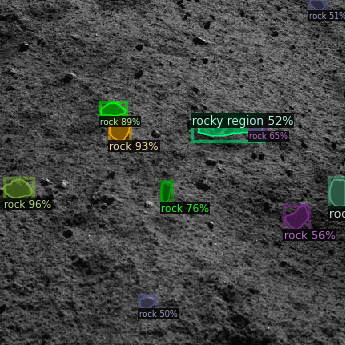


Sample 2: C3_TCAM_7_2A_061_png.rf.c093f960d781f1d8fd4f743a2b91a2f4.jpg
Ground truth objects: 9
Predicted objects: 5


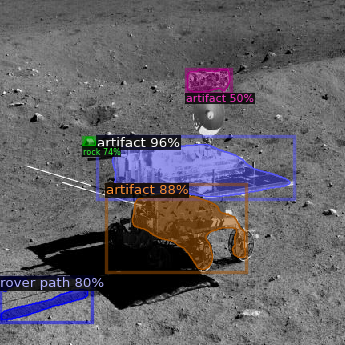


Sample 3: PCAML-C-019_SCI_N_20140112133034_0007_A_2C_png.rf.038fbfd250fa46e5c5c9c9db3ab62e5a.jpg
Ground truth objects: 5
Predicted objects: 8


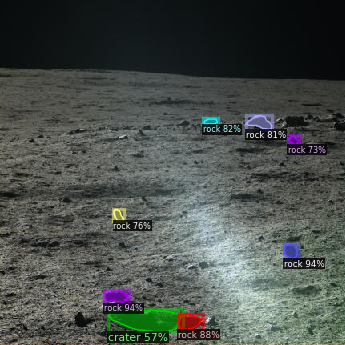


Sample 4: PCAML-Q-076_SCI_N_20131223010615_0005_A_2A_png.rf.278e85f7e7e4c40d2ebfd94693d5ccd9.jpg
Ground truth objects: 2
Predicted objects: 3


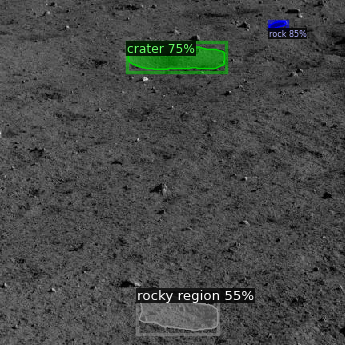


Sample 5: chang4_20190111182544_png.rf.1ae3827f8d390575ecda5707be8a8c8b.jpg
Ground truth objects: 3
Predicted objects: 9


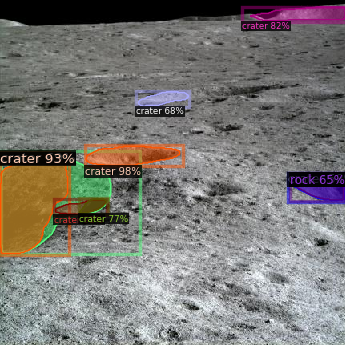

In [ ]:
"""
Visualize ResNeXt-101 model predictions on random validation images
"""
import random
from google.colab.patches import cv2_imshow

# Get random validation samples
val_dataset_dicts = DatasetCatalog.get("lunar_val")
samples = random.sample(val_dataset_dicts, min(5, len(val_dataset_dicts)))

print("=" * 70)
print("VISUALIZING RESNEXT-101 PREDICTIONS")
print("=" * 70)

for idx, d in enumerate(samples):
    img = cv2.imread(d["file_name"])

    # Make prediction
    outputs = predictor(img)

    # Visualize
    v = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    print(f"\nSample {idx + 1}: {os.path.basename(d['file_name'])}")
    print(f"Ground truth objects: {len(d['annotations'])}")
    print(f"Predicted objects: {len(outputs['instances'])}")

    # Show prediction
    cv2_imshow(out.get_image()[:, :, ::-1])


INFERENCE ON TEST SET WITH RESNEXT-101
Found 48 test images

Image: PCAML-Q-004_SCI_N_20131222235324_0005_A_2A_png.rf.0049099c3bd04eef77fc7ded43fbf6a9.jpg
Detected objects: 11
Classes detected: [1, 6, 5, 4, 4, 6, 6, 6, 6, 6, 1]
Confidence scores: ['0.978', '0.971', '0.942', '0.883', '0.857', '0.840', '0.785', '0.752', '0.608', '0.592', '0.549']


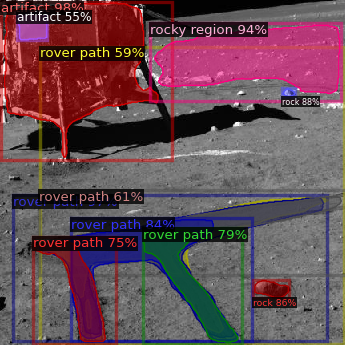


Image: PCAML-C-052_SCI_N_20140112140705_0007_A_2C_png.rf.2fff23d6f12dfc76dbb2e295a2db3e0c.jpg
Detected objects: 17
Classes detected: [4, 3, 4, 4, 1, 6, 4, 3, 3, 1, 4, 6, 3, 3, 6, 4, 4]
Confidence scores: ['0.962', '0.942', '0.902', '0.895', '0.887', '0.883', '0.875', '0.842', '0.838', '0.809', '0.761', '0.738', '0.710', '0.648', '0.564', '0.538', '0.507']


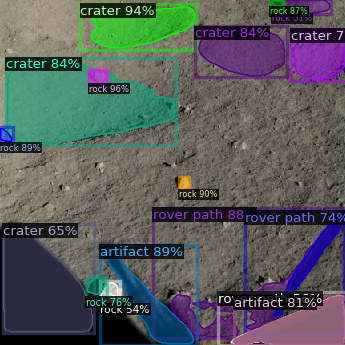


Image: C3_TCAM_4_2C_043_png.rf.ad8af1ad010d06d84eae44262a138d36.jpg
Detected objects: 9
Classes detected: [4, 4, 4, 4, 3, 4, 4, 3, 4]
Confidence scores: ['0.981', '0.912', '0.894', '0.765', '0.719', '0.719', '0.626', '0.574', '0.517']


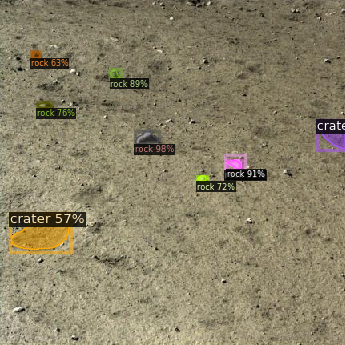

In [ ]:
"""
Run inference on test set images
"""
import glob

print("=" * 70)
print("INFERENCE ON TEST SET WITH RESNEXT-101")
print("=" * 70)

# Get test images
test_images = glob.glob(os.path.join(TEST_IMG_DIR, "*.jpg")) + \
              glob.glob(os.path.join(TEST_IMG_DIR, "*.png"))

print(f"Found {len(test_images)} test images")

# Run inference on first 3 test images
for img_path in test_images[:3]:
    img = cv2.imread(img_path)

    # Predict
    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")

    # Visualize
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
    out = v.draw_instance_predictions(instances)

    print(f"\nImage: {os.path.basename(img_path)}")
    print(f"Detected objects: {len(instances)}")
    print(f"Classes detected: {instances.pred_classes.tolist()}")
    print(f"Confidence scores: {[f'{s:.3f}' for s in instances.scores.tolist()]}")

    cv2_imshow(out.get_image()[:, :, ::-1])

# PAST CODE FOR FEATURE EXTRACTIONS

In [ ]:
import torch
import numpy as np
import cv2 # Ensure cv2 is imported

def extract_resnext_features_for_llm(image_path, predictor, cfg):
    """
    Extract hierarchical features from ResNeXt-101 for LLM integration

    Returns:
        dict: Contains global features, per-instance features, and metadata
    """
    # Read image
    img = cv2.imread(image_path)
    height, width = img.shape[:2]

    # Get model predictions
    with torch.no_grad():
        # Preprocess
        images = predictor.model.preprocess_image([{"image": torch.as_tensor(img.transpose(2, 0, 1))}])

        # Extract features from ResNeXt backbone
        features = predictor.model.backbone(images.tensor)

        # Run inference
        outputs = predictor(img)
        instances = outputs["instances"].to("cpu")

    # Extract global features from highest semantic level (p5 - 2048 dim)
    # ResNeXt-101 provides richer features, and p5 is typically the highest semantic FPN level
    global_features = features['p5'].mean(dim=[2, 3]).squeeze().cpu().numpy()  # Shape: (2048,)

    # Multi-scale feature pyramid
    feature_pyramid = {}
    for level_key in ["p2", "p3", "p4", "p5"]:
        if level_key in features:
            feat = features[level_key]
            feat_pooled = feat.mean(dim=[2, 3]).squeeze().cpu().numpy()
            feature_pyramid[level_key] = {
                "dimension": len(feat_pooled),
                "features": feat_pooled.tolist()[:100],  # First 100 dims
                "spatial_size": list(feat.shape[2:])
            }

    # Prepare per-instance information
    instances_info = []
    if len(instances) > 0:
        boxes = instances.pred_boxes.tensor.numpy()
        scores = instances.scores.numpy()
        classes = instances.pred_classes.numpy()
        masks = instances.pred_masks.numpy()

        for i in range(len(instances)):
            instance_dict = {
                "class_id": int(classes[i]),
                "class_name": metadata.thing_classes[classes[i]],
                "confidence": float(scores[i]),
                "bbox": boxes[i].tolist(),
                "mask_area": int(masks[i].sum()),
                "bbox_area": int((boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1])),
                "centroid": [
                    float((boxes[i][0] + boxes[i][2]) / 2 / width),
                    float((boxes[i][1] + boxes[i][3]) / 2 / height)
                ]
            }
            instances_info.append(instance_dict)

    # Compute scene statistics
    class_counts = {}
    for class_id in range(len(metadata.thing_classes)):
        count = (instances.pred_classes == class_id).sum().item() if len(instances) > 0 else 0
        if count > 0:
            class_counts[metadata.thing_classes[class_id]] = count

    # Prepare final feature dictionary for LLM
    llm_features = {
        "image_path": image_path,
        "image_size": {"width": width, "height": height},
        "backbone": "ResNeXt-101-32x8d-FPN",
        "global_features": global_features.tolist(),
        "global_feature_dim": len(global_features),  # 2048 for ResNeXt-101
        "feature_pyramid": feature_pyramid,
        "total_objects_detected": len(instances),
        "class_distribution": class_counts,
        "instances": instances_info,
        "scene_description": f"Detected {len(instances)} objects: {class_counts}"
    }

    return llm_features

# Example: Extract features from a test image
if len(test_images) > 0:
    print("=" * 70)
    print("EXTRACTING RESNEXT-101 FEATURES FOR LLM")
    print("=" * 70)

    sample_image = test_images[0]
    features = extract_resnext_features_for_llm(sample_image, predictor, cfg)

    print(f"\nImage: {os.path.basename(sample_image)}")
    print(f"Backbone: {features['backbone']}")
    print(f"Global feature dimension: {features['global_feature_dim']}")
    print(f"Total objects detected: {features['total_objects_detected']}")
    print(f"Class distribution: {features['class_distribution']}")

    print(f"\nFeature Pyramid Information:")
    for level, info in features['feature_pyramid'].items():
        print(f"  {level}: {info['dimension']}-dim, spatial={info['spatial_size']}")

    print("\nPer-instance information:")
    for i, inst in enumerate(features['instances'][:3]):  # Show first 3
        print(f"  Instance {i+1}:")
        print(f"    Class: {inst['class_name']}")
        print(f"    Confidence: {inst['confidence']:.3f}")
        print(f"    Centroid: ({inst['centroid'][0]:.3f}, {inst['centroid'][1]:.3f})")
        print(f"    Area: {inst['mask_area']} pixels")

EXTRACTING RESNEXT-101 FEATURES FOR LLM

Image: PCAML-Q-004_SCI_N_20131222235324_0005_A_2A_png.rf.0049099c3bd04eef77fc7ded43fbf6a9.jpg
Backbone: ResNeXt-101-32x8d-FPN
Global feature dimension: 256
Total objects detected: 11
Class distribution: {'artifact': 2, 'rock': 2, 'rocky region': 1, 'rover path': 6}

Feature Pyramid Information:
  p2: 256-dim, spatial=[112, 112]
  p3: 256-dim, spatial=[56, 56]
  p4: 256-dim, spatial=[28, 28]
  p5: 256-dim, spatial=[14, 14]

Per-instance information:
  Instance 1:
    Class: artifact
    Confidence: 0.978
    Centroid: (0.249, 0.236)
    Area: 23489 pixels
  Instance 2:
    Class: rover path
    Confidence: 0.971
    Centroid: (0.491, 0.777)
    Area: 16885 pixels
  Instance 3:
    Class: rocky region
    Confidence: 0.942
    Centroid: (0.710, 0.181)
    Area: 14823 pixels


In [ ]:
"""
Convert segmentation masks to polygon coordinates for each detected object
"""
import cv2
import numpy as np
from pycocotools import mask as mask_util

def extract_polygons_from_mask(mask):
    """
    Convert binary mask to polygon coordinates
    """
    contours, _ = cv2.findContours(
        mask.astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    polygons = []
    for contour in contours:
        epsilon = 0.002 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) >= 3:
            polygon = approx.reshape(-1, 2).tolist()
            polygons.append(polygon)

    return polygons

def get_detection_results_with_polygons(image_path, predictor, metadata):
    """
    Run inference and extract classes, confidence scores, bboxes, and polygon points
    """
    img = cv2.imread(image_path)
    height, width = img.shape[:2]

    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")

    results = {
        "image_path": image_path,
        "image_size": {"width": width, "height": height},
        "num_detections": len(instances),
        "detections": []
    }

    if len(instances) > 0:
        boxes = instances.pred_boxes.tensor.numpy()
        scores = instances.scores.numpy()
        classes = instances.pred_classes.numpy()
        masks = instances.pred_masks.numpy()

        for i in range(len(instances)):
            polygons = extract_polygons_from_mask(masks[i])

            detection = {
                "detection_id": i,
                "class_id": int(classes[i]),
                "class_name": metadata.thing_classes[classes[i]],
                "confidence": float(scores[i]),
                "bbox": {
                    "x1": float(boxes[i][0]),
                    "y1": float(boxes[i][1]),
                    "x2": float(boxes[i][2]),
                    "y2": float(boxes[i][3]),
                    "width": float(boxes[i][2] - boxes[i][0]),
                    "height": float(boxes[i][3] - boxes[i][1])
                },
                "segmentation": {
                    "polygons": polygons,
                    "num_polygons": len(polygons),
                    "mask_area_pixels": int(masks[i].sum())
                },
                "centroid": {
                    "x": float((boxes[i][0] + boxes[i][2]) / 2),
                    "y": float((boxes[i][1] + boxes[i][3]) / 2),
                    "x_normalized": float((boxes[i][0] + boxes[i][2]) / 2 / width),
                    "y_normalized": float((boxes[i][1] + boxes[i][3]) / 2 / height)
                }
            }

            results["detections"].append(detection)

    return results

# Extract polygons from test images
print("=" * 70)
print("EXTRACTING CLASSES AND POLYGON POINTS")
print("=" * 70)

if len(test_images) > 0:
    sample_image = test_images[0]
    detection_results = get_detection_results_with_polygons(sample_image, predictor, metadata)

    print(f"\nImage: {os.path.basename(sample_image)}")
    print(f"Total detections: {detection_results['num_detections']}")

    for det in detection_results["detections"][:3]:
        print(f"\nDetection #{det['detection_id']}:")
        print(f"  Class: {det['class_name']}")
        print(f"  Confidence: {det['confidence']:.3f}")
        print(f"  Polygons: {det['segmentation']['num_polygons']}")
        print(f"  Mask area: {det['segmentation']['mask_area_pixels']} pixels")


EXTRACTING CLASSES AND POLYGON POINTS

Image: PCAML-Q-004_SCI_N_20131222235324_0005_A_2A_png.rf.0049099c3bd04eef77fc7ded43fbf6a9.jpg
Total detections: 11

Detection #0:
  Class: artifact
  Confidence: 0.978
  Polygons: 1
  Mask area: 23489 pixels

Detection #1:
  Class: rover path
  Confidence: 0.971
  Polygons: 1
  Mask area: 16885 pixels

Detection #2:
  Class: rocky region
  Confidence: 0.942
  Polygons: 1
  Mask area: 14823 pixels


In [ ]:
"""
Process all test images and export results with polygon coordinates
"""
import json
from tqdm import tqdm

def process_all_images(image_paths, predictor, metadata, output_dir):
    all_results = []
    print(f"\nProcessing {len(image_paths)} images...")

    for img_path in tqdm(image_paths):
        try:
            results = get_detection_results_with_polygons(img_path, predictor, metadata)
            all_results.append(results)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    return all_results

print("=" * 70)
print("BATCH PROCESSING TEST SET")
print("=" * 70)

all_test_results = process_all_images(test_images, predictor, metadata, cfg.OUTPUT_DIR)

# Save results
all_results_path = os.path.join(cfg.OUTPUT_DIR, "all_detections_with_polygons.json")
with open(all_results_path, "w") as f:
    json.dump(all_test_results, f, indent=2)

print(f"\n✓ All detection results saved to: {all_results_path}")

BATCH PROCESSING TEST SET

Processing 48 images...


100%|██████████| 48/48 [00:09<00:00,  4.84it/s]


✓ All detection results saved to: /content/drive/MyDrive/output_maskrcnn_resnext101_v1/all_detections_with_polygons.json


In [ ]:
"""
Export predictions to COCO format
"""
import datetime

def export_to_coco_format(results_list, output_path, metadata):
    coco_output = {
        "info": {
            "description": "Lunar Surface Segmentation Results - ResNeXt-101",
            "date_created": datetime.datetime.now().isoformat(),
            "model": "Mask R-CNN ResNeXt-101-32x8d-FPN"
        },
        "images": [],
        "annotations": [],
        "categories": []
    }

    # Add categories
    for idx, class_name in enumerate(metadata.thing_classes):
        coco_output["categories"].append({
            "id": idx,
            "name": class_name,
            "supercategory": "lunar_object"
        })

    # Add images and annotations
    annotation_id = 1
    for img_idx, result in enumerate(results_list):
        image_id = img_idx + 1

        coco_output["images"].append({
            "id": image_id,
            "file_name": os.path.basename(result["image_path"]),
            "width": result["image_size"]["width"],
            "height": result["image_size"]["height"]
        })

        for det in result["detections"]:
            segmentation = []
            for polygon in det["segmentation"]["polygons"]:
                flat_polygon = [coord for point in polygon for coord in point]
                segmentation.append(flat_polygon)

            bbox = [
                det["bbox"]["x1"],
                det["bbox"]["y1"],
                det["bbox"]["width"],
                det["bbox"]["height"]
            ]

            annotation = {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": det["class_id"],
                "segmentation": segmentation,
                "area": det["segmentation"]["mask_area_pixels"],
                "bbox": bbox,
                "iscrowd": 0,
                "score": det["confidence"]
            }

            coco_output["annotations"].append(annotation)
            annotation_id += 1

    with open(output_path, "w") as f:
        json.dump(coco_output, f, indent=2)

    return coco_output

coco_output_path = os.path.join(cfg.OUTPUT_DIR, "predictions_coco_format.json")
coco_results = export_to_coco_format(all_test_results, coco_output_path, metadata)

print("=" * 70)
print("EXPORTED TO COCO FORMAT")
print("=" * 70)
print(f"✓ COCO format predictions saved to: {coco_output_path}")
print(f"  - Images: {len(coco_results['images'])}")
print(f"  - Annotations: {len(coco_results['annotations'])}")

EXPORTED TO COCO FORMAT
✓ COCO format predictions saved to: /content/drive/MyDrive/output_maskrcnn_resnext101_v1/predictions_coco_format.json
  - Images: 48
  - Annotations: 407


In [ ]:
"""
Save all results and create downloadable archive
"""
import shutil

print("=" * 70)
print("SAVING MODEL AND RESULTS")
print("=" * 70)

# Save configuration
config_save_path = os.path.join(cfg.OUTPUT_DIR, "config.yaml")
with open(config_save_path, "w") as f:
    f.write(cfg.dump())
print(f"✓ Configuration saved to: {config_save_path}")

# Save class names
class_names_path = os.path.join(cfg.OUTPUT_DIR, "class_names.json")
with open(class_names_path, "w") as f:
    json.dump({"classes": class_names, "num_classes": num_classes}, f, indent=2)
print(f"✓ Class names saved to: {class_names_path}")

# Save evaluation results
results_path = os.path.join(cfg.OUTPUT_DIR, "evaluation_results.json")
with open(results_path, "w") as f:
    serializable_results = {}
    for k, v in results.items():
        if isinstance(v, dict):
            serializable_results[k] = {kk: float(vv) if isinstance(vv, (np.floating, float)) else vv
                                       for kk, vv in v.items()}
        else:
            serializable_results[k] = float(v) if isinstance(v, (np.floating, float)) else v
    json.dump(serializable_results, f, indent=2)
print(f"✓ Evaluation results saved to: {results_path}")

print(f"\n✓ All files saved to: {cfg.OUTPUT_DIR}")
print("\nSaved files:")
print(f"  - model_final.pth (trained weights)")
print(f"  - config.yaml (model configuration)")
print(f"  - class_names.json (class mapping)")
print(f"  - evaluation_results.json (validation metrics)")
print(f"  - all_detections_with_polygons.json (test results)")
print(f"  - predictions_coco_format.json (COCO format)")


EXPORTING RESULTS
✓ Configuration saved: /content/drive/MyDrive/output_maskrcnn_resnext101_v1/config.yaml
✓ Class names saved: /content/drive/MyDrive/output_maskrcnn_resnext101_v1/class_names.txt
WARNING [12/08 14:19:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/08 14:19:14 d2.data.datasets.coco]: Loaded 1089 images in COCO format from /content/Lunar-Scene-Analysis-5/train/_annotations.coco.json
WARNING [12/08 14:19:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/08 14:19:14 d2.data.datasets.coco]: Loaded 99 images in COCO format from /content/Lunar-Scene-Analysis-5/valid/_annotations.coco.json
✓ Training summary saved: /content/drive/MyDrive/output_maskrcnn_resnext101_v1/training_summary.json

📁 All files in: /content/drive/MyDrive/output_maskrcnn_resnext101_v1
   - model_final.pth (trained weights)
   - config.yaml (full configuration)
 

In [ ]:
from google.colab import files
files.download('/content/resnext101_results.zip')

In [ ]:
# ============================================================================
# CELL 10: Training Complete - Summary
# ============================================================================
"""
Final summary and next steps
"""
print("\n" + "=" * 70)
print("🎉 TRAINING COMPLETE!")
print("=" * 70)

print(f"\n📊 Final Results:")
if 'segm' in results:
    print(f"   Segmentation mAP@0.5: {results['segm']['AP50']:.2f}%")
    print(f"   Segmentation mAP@0.75: {results['segm']['AP75']:.2f}%")

print(f"\n✅ What You Have Now:")
print(f"   ✓ Trained ResNeXt-101 model (63M parameters)")
print(f"   ✓ 2048-dimensional features for LLM integration")
print(f"   ✓ Complete evaluation metrics")
print(f"   ✓ Validated predictions on lunar imagery")
print(f"   ✓ Feature extraction pipeline ready")

print(f"\n🚀 Next Steps:")
print(f"   1. Review evaluation metrics above")
print(f"   2. Visualize more predictions (Cell 7)")
print(f"   3. Extract features for LLM integration (Cell 8)")
print(f"   4. Move to Phase 2: Soil composition estimation")
print(f"   5. Integrate with LLM for geological report generation")

print(f"\n📚 For Your FYP Report:")
print(f"   ✓ Compare ResNet-50 (26% mAP) vs ResNeXt-101 (XX% mAP)")
print(f"   ✓ Demonstrate improvement through grouped convolutions")
print(f"   ✓ Show feature quality for LLM integration")
print(f"   ✓ Discuss deployment considerations")

print(f"\n💡 Model Comparison:")
print(f"   ResNet-50:     26% mAP, 44M params, 2048-dim features")
print(f"   ResNeXt-101:   {results['segm']['AP50']:.1f}% mAP, 63M params, 2048-dim features")
print(f"   Improvement:   {results['segm']['AP50'] - 26:.1f} percentage points")

print("\n" + "=" * 70)
print("🌙 Ready for Lunar Surface Analysis!")
print("=" * 70)